# Frequency analysis using RMM
FFT, power spectrum, power spectrum density, relationship with variance, power × frequency, and autocorrelation using RMM indices

In [1]:
import numpy as np
from scipy import fft, signal, integrate, ndimage
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# RMM index
f = 'data/rmm.csv'
df = pd.read_csv(f, index_col=0, parse_dates=True).dropna()

Time series data: $x(t)$  
Fourier Transformed data: $X(\omega) = \int x(t) e^{-j\omega t} dt$  
Power Spectrum: $ S(\omega) = |X(\omega)|^2 $  
Power Spectrum Density (PSD): $ |X(\omega)|^2 / \tau $  

where $\tau$ is duration.

In [3]:
# Focus on RMM1 (assume continous data for simiplicity)
t = np.arange(df.shape[0])
x = df['RMM1'].values
fs = 1   # Sampling frequency

# FFT
x_fft = fft.rfft(x)
freq = fft.rfftfreq(len(x), d=1/fs) 
ps = np.abs(x_fft) ** 2
freq, psd = signal.periodogram(x, fs=fs)

print(f'{x.shape = :}')
print(f'{t.shape = :}')
print(f'{x_fft.shape = :}')
print(f'{freq.shape = :}')
print(f'{psd.shape = :}')

print(f'PSD should match except for the zero frequency: '
      f'{np.allclose(psd[1:], ps[1:] / (len(x) * fs) * 2)}')

x.shape = (16455,)
t.shape = (16455,)
x_fft.shape = (8228,)
freq.shape = (8228,)
psd.shape = (8228,)
PSD should match except for the zero frequency: True


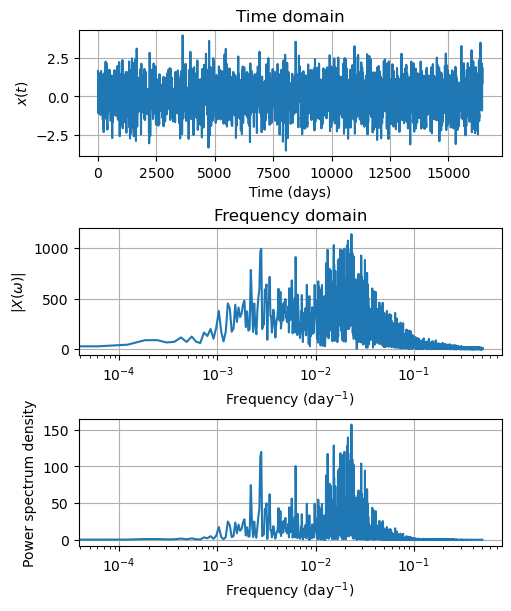

In [4]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5, 6), layout='constrained')

ax = axs[0]
ax.plot(t, x)
ax.set(
    title='Time domain',
    xlabel='Time (days)',
    ylabel=r'$x(t)$',
)
ax.grid()

ax = axs[1]
ax.plot(freq, np.abs(x_fft))
ax.set(
    xscale='log',
    title='Frequency domain',
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel=r'$|X(\omega)|$',
)
ax.grid()

ax = axs[2]
ax.plot(freq, psd)
ax.set(
    xscale='log',
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power spectrum density',
)
ax.grid()

The integral of PSD is equal to the variance of the signal

In [5]:
print(f'Variance = {x.var():.4f}')
print(f'integral psd df = {integrate.trapezoid(psd, x=freq):.4f}')
print(f'integral psd*f ln(df) = {integrate.trapezoid((psd*freq)[1:], x=np.log(freq[1:])):.4f}')

Variance = 1.0216
integral psd df = 1.0216
integral psd*f ln(df) = 1.0216


### log(frequency) vs power × frequency plot
The area under any portion of the curve is equal to the variance within that frequency band.

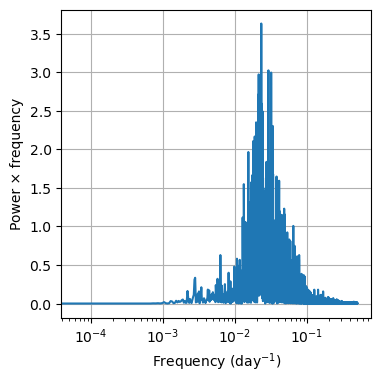

In [6]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.semilogx(freq, psd*freq)
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power × frequency',
)
ax.grid()

It is common to smooth the power density to reduce noise.

This plot is similar to Fig. 2 of [Wheeler and Hendon (2004)](https://doi.org/10.1175/1520-0493%282004%29132<1917:AARMMI>2.0.CO;2).

In [7]:
# Gaussian filter
sigma = 10  # Standard deviation for Gaussian kernel
psd_smth = ndimage.gaussian_filter(psd, sigma)

In [8]:
total_variance = integrate.trapezoid(psd_smth, x=freq)
print(f'{total_variance = :.4f}')

# Explained variance in 30- to 80-day band
idx = (freq > 1/80) & (freq < 1/30)
band_variance = integrate.trapezoid(psd_smth[idx], x=freq[idx])
# band_variance = integrate.trapezoid(psd_smth[idx]*freq[idx], x=np.log(freq[idx]))
print(f'Fractional variance = {band_variance / total_variance:.4f}')

total_variance = 1.0215
Fractional variance = 0.5714


/tmp/ipykernel_422391/52485128.py:19: RuntimeWarning: divide by zero encountered in divide
  sax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))


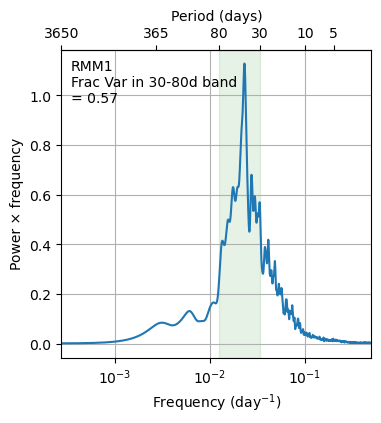

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.semilogx(freq, psd_smth*freq)
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power × frequency',
    xlim=(1/3650, freq[-1]),
)
ax.grid()
ax.minorticks_off()
ax.text(
    0.03, 0.97, 
    f'RMM1\nFrac Var in 30-80d band\n= {band_variance / total_variance:.2f}', 
    ha='left', va='top', transform=ax.transAxes
)

# Secondary axis
xticks = [5, 10, 30, 80, 365, 3650]
sax = ax.secondary_xaxis('top', functions=(lambda x: 1/x, lambda x: 1/x))
sax.set(
    xlabel='Period (days)',
    xticks=xticks,
    xticklabels=xticks,
)
sax.minorticks_off()

ax.axvspan(1/80, 1/30, color='g', alpha=0.1)

### Autocorrelation & power spectrum
Autocorrelation:  
$$\rho (\tau) = \int x(t) x(t+\tau) dt$$

Fourier Transform of the autocorrelation:
$$ S(\omega) = \int \rho(\tau) e^{-j\omega \tau} d\tau $$

In [10]:
acf = signal.correlate(x, x, mode='same')

nlag = len(acf) // 2
lag = np.arange(-nlag, nlag+1)

# FFT of ACF
ps_acf = np.abs(fft.rfft(acf))

print(f'{acf.shape = :}')
print(f'{ps_acf.shape = :}')

acf.shape = (16455,)
ps_acf.shape = (8228,)


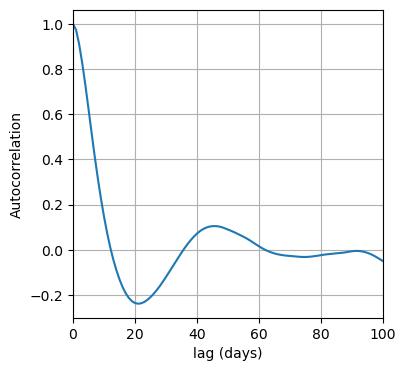

In [11]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.plot(lag, acf / x.var() / x.size)
ax.set(
    xlim=(0, 100),
    ylabel='Autocorrelation',
    xlabel='lag (days)',
)
ax.grid()


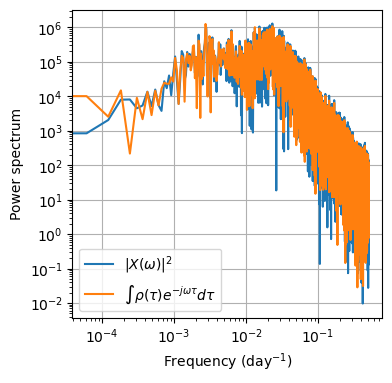

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))

ax.loglog(freq, ps, label=r'${|X(\omega)|^2}$')
ax.loglog(freq, ps_acf, label=r'$\int \rho(\tau) e^{-j\omega \tau} d\tau$')
ax.legend()
ax.set(
    xlabel=r'Frequency ($\mathrm{day^{-1}}$)',
    ylabel='Power spectrum',
)
ax.grid()